In [1]:
import netCDF4 as nc
from netCDF4 import Dataset
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# gsw oceanic toolbox: http://www.teos-10.org/pubs/Getting_Started.pdf
import gsw
from scipy.io import loadmat
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

In [543]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [612]:
arctic_mix = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/arctic_mix.nc"
alberto_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/alberto_ds.nc"
global_pkl = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/input_microstructure.pkl"
global_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/L2_2D_snapshot_iy150_model_input.nc"
mosaic_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/mosaic_ds.nc"
nice_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/nice_ds.nc"
HM_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/HM_ds.nc"
NN_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/L2_2D_snapshot_iy150_model_input.nc"

arctic_ds = xr.open_dataset(arctic_mix)
alberto_ds = xr.open_dataset(alberto_nc)
global_ds = pd.read_pickle(global_pkl)
global_nn = xr.open_dataset(global_nc)
mosaic_ds = xr.open_dataset(mosaic_nc)
nice_ds = xr.open_dataset(nice_nc)
HM_ds = xr.open_dataset(HM_nc)
NN_ds = xr.open_dataset(NN_nc)

In [613]:
GEBCO_ds = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/gebco_2022_n80.0_s63.0_w-170.0_e-130.0.nc"
#bathy_dataset = Dataset(GEBCO_ds)
bathy_ds = xr.open_dataset(GEBCO_ds)

In [614]:
def check_coords(data):
    if "latitude" not in data.coords:
        data = data.set_coords("latitude")
    if "longitude" not in data.coords:
        data = data.set_coords("longitude")
    if "time" not in data.coords:
        data = data.set_coords("time")
    if "depth" not in data.coords:
        data["depth"] = data.depth
    return data

In [615]:
# define common coordinates across all datasets
coords = {"latitude": "lat", "longitude": "lon", "depth": "depth", "profile": "profile"}

## Add all features and combine all datasets into one dataframe
The features and the plots are explained below

In [616]:
HM_kappa = HM_ds.squeeze()
arctic_ds = arctic_ds.squeeze()
HM_kappa = HM_kappa.transpose('depth', 'profile')

nice_kappa = calc_N2_kappa(nice_ds)
mosaic_kappa = calc_N2_kappa(mosaic_ds)
HM_kappa = calc_N2_kappa(HM_kappa)
arctic_kappa = calc_N2_kappa(arctic_ds)
alberto_kappa = calc_N2_kappa(alberto_ds)

arctic_final = arctic_calchab(arctic_kappa)
nice_final = calc_hab(nice_kappa)
mosaic_final = calc_hab(mosaic_kappa)
HM_final = calc_hab(HM_kappa)
alberto_final = calc_hab(alberto_kappa)

871it [00:01, 777.74it/s]
100%|██████████| 351/351 [00:00<00:00, 1323.63it/s]


In [617]:
# add variables of the cruise name
arctic_final["cruise"] = "ArcticMix"
nice_final["cruise"] = "NICE"
mosaic_final["cruise"] = "Mosaic"
alberto_final["cruise"] = "Alberto"
HM_final["cruise"] = "HM"

In [618]:
nice_selected = nice_final.drop_vars(['time', 'LATITUDE', "LONGITUDE"])


In [619]:
arctic_df = arctic_final.to_dataframe().reset_index()
HM_df = HM_final.to_dataframe().reset_index()
mosaic_df = mosaic_final.to_dataframe().reset_index()
alberto_df = alberto_final.to_dataframe().reset_index()
nice_df = nice_selected.to_dataframe().reset_index()

In [620]:
combined_df = pd.concat([arctic_df, HM_df, mosaic_df, alberto_df, nice_df])

In [621]:
selected_columns = ["depth", "profile", "latitude", "longitude", "P", "S", "insituT", "T", "Tu", "Rsubrho", "N2", "kappa", "log_N2", "log_kappa", "dTdz", "dSdz", "bathymetry", "eps", "cruise", "hab"]
combined_df_selected = combined_df[selected_columns]

In [625]:
nan_counts = combined_df_selected.isna().sum()
nan_counts

depth              0
profile            0
latitude           0
longitude          0
P             118193
S             230220
insituT       351991
T             354467
Tu            366675
Rsubrho       397091
N2            366675
kappa         377451
log_N2        534757
log_kappa     927073
dTdz          364496
dSdz          238784
bathymetry         0
eps           368177
cruise             0
hab                0
dtype: int64

In [628]:
check = combined_df_selected.copy()

check.dropna(how='any', inplace=True)
check

,depth,profile,latitude,longitude,P,S,insituT,T,Tu,Rsubrho,N2,kappa,log_N2,log_kappa,dTdz,dSdz,bathymetry,eps,cruise,hab
982,1.0,111.0,70.034487,-138.990825,1.625,16.469607,2.948691,2.948650,-50.530369,0.096824,1.861007e-05,1137.563479,-4.730252,3.055976,-0.021724,0.003323,-216.0,1.058507e-01,ArcticMix,-215.0
1010,1.0,139.0,70.046968,-138.918547,1.625,16.667362,1.972356,1.972330,33.414301,-4.877801,1.657058e-04,60.664499,-3.780662,1.782935,-0.820940,0.003696,-275.0,5.026228e-02,ArcticMix,-274.0
1144,1.0,273.0,72.179566,-147.782022,1.625,16.648159,-0.891000,-0.890980,-47.763332,0.048267,2.469178e-05,31.568531,-4.607448,1.499254,-0.004669,0.003137,-3575.0,3.897417e-03,ArcticMix,-3574.0
1208,1.0,337.0,72.180953,-147.891479,1.625,16.799098,-0.950161,-0.950141,-45.553118,0.009654,6.333895e-05,31.374888,-4.198329,1.496582,0.006767,0.008267,-3587.0,9.936262e-03,ArcticMix,-3586.0
1210,1.0,339.0,72.179871,-147.902405,1.625,16.792235,-0.972886,-0.972866,-45.222173,0.003878,7.064515e-05,79.209161,-4.150918,1.898775,-0.002420,0.008788,-3584.0,2.797872e-02,ArcticMix,-3583.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176351,251.0,1688.0,80.367503,7.437229,251.600,35.037559,2.916968,2.901365,84.124298,1.229434,9.519497e-07,0.000440,-6.021386,-3.356801,-0.005061,-0.000342,-3360.0,2.093068e-09,NICE,-3109.0
176352,252.0,1688.0,80.367503,7.437229,252.600,35.037018,2.911662,2.896006,89.169516,1.029418,8.465777e-08,0.006860,-7.072333,-2.163694,-0.004236,-0.000458,-3360.0,2.903642e-09,NICE,-3108.0
176353,253.0,1688.0,80.367503,7.437229,253.600,35.036643,2.908606,2.892892,48.976581,14.385160,4.646725e-06,0.000115,-5.332853,-3.939412,-0.004179,-0.000211,-3360.0,2.671191e-09,NICE,-3107.0
176354,254.0,1688.0,80.367503,7.437229,254.600,35.036597,2.903414,2.887647,43.654148,-42.564309,4.176994e-06,0.000172,-5.379136,-3.764879,-0.004766,-0.000017,-3360.0,3.588850e-09,NICE,-3106.0


In [629]:
combined_df_selected.to_pickle('/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/ml_ready/arctic2_1805.pkl')

## Visualise all the points

total amount of profiles is:  3001


/Users/Lisanne/opt/anaconda3/envs/arcticT/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:538: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/Users/Lisanne/opt/anaconda3/envs/arcticT/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:511: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().get_tightbbox(renderer, *args, **kwargs)
/Users/Lisanne/opt/anaconda3/envs/arcticT/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


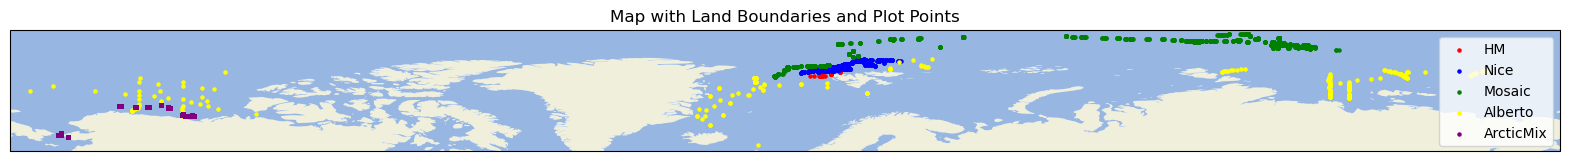

In [9]:
total_profiles = len(HM_ds["longitude"]) + len(nice_ds["longitude"]) + len(mosaic_ds["longitude"]) + len(alberto_ds["longitude"]) + len(arctic_ds["longitude"])
print("total amount of profiles is: ", total_profiles)
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.scatter(HM_ds["longitude"], HM_ds["latitude"], transform=ccrs.PlateCarree(), color='red', s=5, label = "HM")
ax.scatter(nice_ds["longitude"], nice_ds["latitude"], transform=ccrs.PlateCarree(), color='blue', s=5, label = "Nice")
ax.scatter(mosaic_ds["longitude"], mosaic_ds["latitude"], transform=ccrs.PlateCarree(), color='green', s=5, label = "Mosaic")
ax.scatter(alberto_ds["longitude"], alberto_ds["latitude"], transform=ccrs.PlateCarree(), color='yellow', s=5, label = "Alberto")
ax.scatter(arctic_ds["longitude"], arctic_ds["latitude"], transform=ccrs.PlateCarree(), color='purple', s=5, label = "ArcticMix")

# Add land, ocean, and borders
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))

#ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.set_title("Map with Land Boundaries and Plot Points")
ax.legend()
plt.show()

In [10]:
# focus on the Svalbard Islands
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.scatter(HM_ds["longitude"], HM_ds["latitude"], transform=ccrs.PlateCarree(), color='red', s=5, label = "HM")
ax.scatter(nice_ds["longitude"], nice_ds["latitude"], transform=ccrs.PlateCarree(), color='blue', s=5, label = "Nice")
ax.scatter(mosaic_ds["longitude"], mosaic_ds["latitude"], transform=ccrs.PlateCarree(), color='green', s=5, label = "Mosaic")
ax.scatter(alberto_ds["longitude"], alberto_ds["latitude"], transform=ccrs.PlateCarree(), color='yellow', s=5, label = "Alberto")
ax.scatter(arctic_ds["longitude"], arctic_ds["latitude"], transform=ccrs.PlateCarree(), color='purple', s=5, label = "ArcticMix")

# Add land, ocean, and borders
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))

ax.set_extent([-30, 50, 70, 90], crs=ccrs.PlateCarree())
ax.set_title("Map with Land Boundaries and Plot Points")
ax.legend()
plt.show()


: 

: 

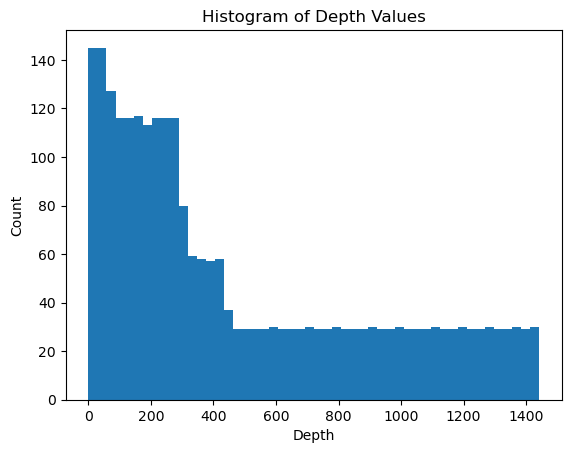

In [6]:
# Select the depth variable from each dataset
depth1 = arctic_ds['depth'].sel()
depth2 = alberto_ds['depth'].sel()
depth3 = nice_ds['depth'].sel()
depth4 = mosaic_ds['depth'].sel()
depth5 = HM_ds['depth'].sel()

# Concatenate the depth values into a single array
depth_values = np.concatenate([depth1.values, depth2.values, depth3.values, depth4.values, depth5.values])

# Plot a histogram of the combined depth values
plt.hist(depth_values, bins=50)
plt.xlabel('Depth')
plt.ylabel('Count')
plt.title('Histogram of Depth Values')
plt.show()

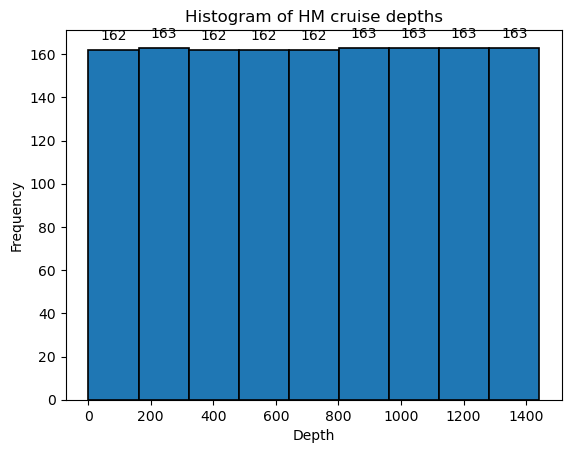

In [7]:
# take the max depth for every profile
max_depths = HM_ds.depth.values
fig, ax = plt.subplots()
n, bins, patches = plt.hist(max_depths, bins=9, edgecolor='black', linewidth=1.2)
# Add labels and title
plt.xlabel('Depth')
plt.ylabel('Frequency')
plt.title('Histogram of HM cruise depths')

# Add text labels to each bin
for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width() / 2
    y = patches[i].get_height()
    ax.annotate(str(int(y)), xy=(x, y), xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')

# Show the plot
plt.show()

# From now on, pretend like nice_ds is the combined_ds


## Calculate features like in Mashayek et al. (2021)

In [532]:
def TS_derivative(dataset):
  dataset["dTdz"] = dataset.T.differentiate('depth')
  dataset['dSdz'] = dataset.S.differentiate('depth')
  return dataset

In [534]:
from scipy.interpolate import interp1d

In [535]:
def interpolate_pmid(dataset, variable):
    original_depth = dataset.depth  # Assuming you have access to the original depth values
    depth_old = np.arange(variable.shape[0])  # Depth values of the variable

    # Extend the depth array to include the boundary value
    depth_new = np.append(depth_old, original_depth[-1])

    # Extend the variable array to include the boundary value
    #new_array = np.column_stack((variable, variable[:, -1])
    new_array = np.vstack((variable, variable[-1, :]))

    # Create a 1D interpolation function along the depth dimension
    interp_func = interp1d(depth_new, new_array, axis=0, kind='linear')
    # Interpolate the variable to match the original depth dimension
    var_interp = interp_func(original_depth)

    # Create a DataArray with explicit dimension names
    var_dataarray = xr.DataArray(var_interp, dims=('depth', 'profile'))
    return var_dataarray


In [530]:
def calc_N2_kappa(dataset):
    """N2 and kappa both independent of epsilon

    Parameters
    ----------
    dataset : dataset
        Microstructure dataset, where insitu temperature is named as "T" in degrees Celcius.
        Salinity is named as "S" in .., and depth is called "depth" in meters.
    """
    S = dataset.S
    P = dataset.P
    lon = dataset.longitude.squeeze()
    lat = dataset.latitude.squeeze()
    T = dataset.T
    eps = dataset.eps
    z = dataset.depth

    # Add a dummy axis to pressure (P) to match the shape of other variables
    if T.shape != P.shape:
        # Project the lower-dimensional variable onto the target dimension
        P = np.expand_dims(P, axis=1)
        
    # convert measured T to potential T, which is seen as temperature now
    # potential temperature is the temperature a water parcel would have 
    # if it were brought to the surface adiabatically (no pressure effects)
    dataset = dataset.rename({"T": "insituT"})
    dataset["T"] = gsw.conversions.pt_from_t(S, T, P, p_ref = 0)
    
    dataset['rho'] = gsw.rho(S, T, P)
    dataset["SA"] = gsw.SA_from_SP(S, P, lon, lat)
    dataset["CT"] = gsw.CT_from_t(dataset.SA, T, P)
    
    # calculate the turner angle
    # The values of Turner Angle Tu and density ratio Rrho are calculated at mid-point pressures, p_mid.
    # https://teos-10.org/pubs/gsw/html/gsw_Turner_Rsubrho.html
    [Tu, Rsubrho, p_mid] = gsw.Turner_Rsubrho(dataset.SA, dataset.CT, P)

    dataset["Tu"] = interpolate_pmid(dataset, Tu)
    dataset["Rsubrho"] = interpolate_pmid(dataset, Rsubrho)
    
    # Calculate N^2 using gsw_Nsquared
    # https://teos-10.org/pubs/gsw/html/gsw_Nsquared.html
    [N2, p_mid] = gsw.Nsquared(SA=dataset["SA"], CT=dataset["CT"], p=P, lat=dataset["latitude"])
    dataset["N2"] = interpolate_pmid(dataset, N2)
    
    # Calculate kappa using gsw_kappa
    # dataset["kappa"] = gsw.kappa(SA=dataset["SA"], CT=dataset["CT"], p=P)
    
    # calculate kappa like in Mashayek et al, 2022
    dataset['kappa'] = 0.2*dataset.eps/dataset.N2 # 0.2 in standard turbulence regime
    # assume mixing efficiency of 1 in double diffusion regime
    dataset["kappa_AT"] = dataset.eps/dataset.N2
    
    dataset["log_N2"] = np.log10(dataset.N2)
    dataset["log_kappa"] = np.log10(dataset.kappa)
    
    dataset = TS_derivative(dataset)
    return dataset

In [536]:
from matplotlib import colors

/Users/Lisanne/opt/anaconda3/envs/arcticT/lib/python3.11/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


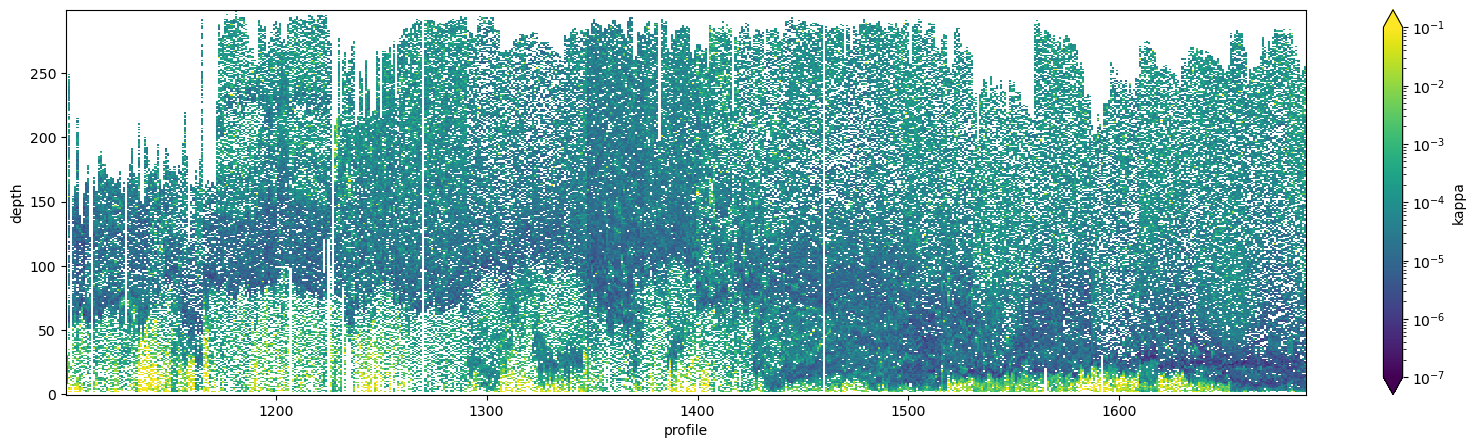

In [537]:
nice_kappa = calc_N2_kappa(nice_ds)
nice_kappa.kappa.plot(y = 'depth',norm = colors.LogNorm(vmin = 1e-7, vmax = 1e-1),cmap='viridis',figsize=(20,5))

/Users/Lisanne/opt/anaconda3/envs/arcticT/lib/python3.11/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


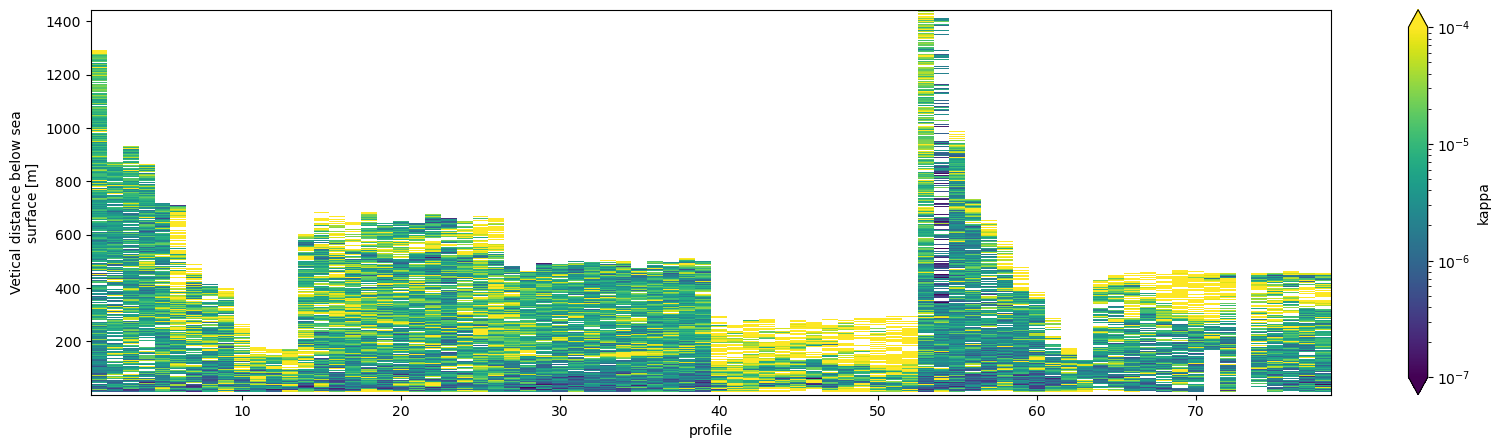

In [538]:
HM_kappa = HM_ds.squeeze()
HM_kappa = HM_kappa.transpose('depth', 'profile')
HM = calc_N2_kappa(HM_kappa)
HM.kappa.plot(y = 'depth',norm = colors.LogNorm(vmin = 1e-7, vmax = 1e-4),cmap='viridis',figsize=(20,5))

/Users/Lisanne/opt/anaconda3/envs/arcticT/lib/python3.11/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in pt_from_t
  result_data = func(*input_data)
/Users/Lisanne/opt/anaconda3/envs/arcticT/lib/python3.11/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in ct_from_t
  result_data = func(*input_data)
/Users/Lisanne/opt/anaconda3/envs/arcticT/lib/python3.11/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


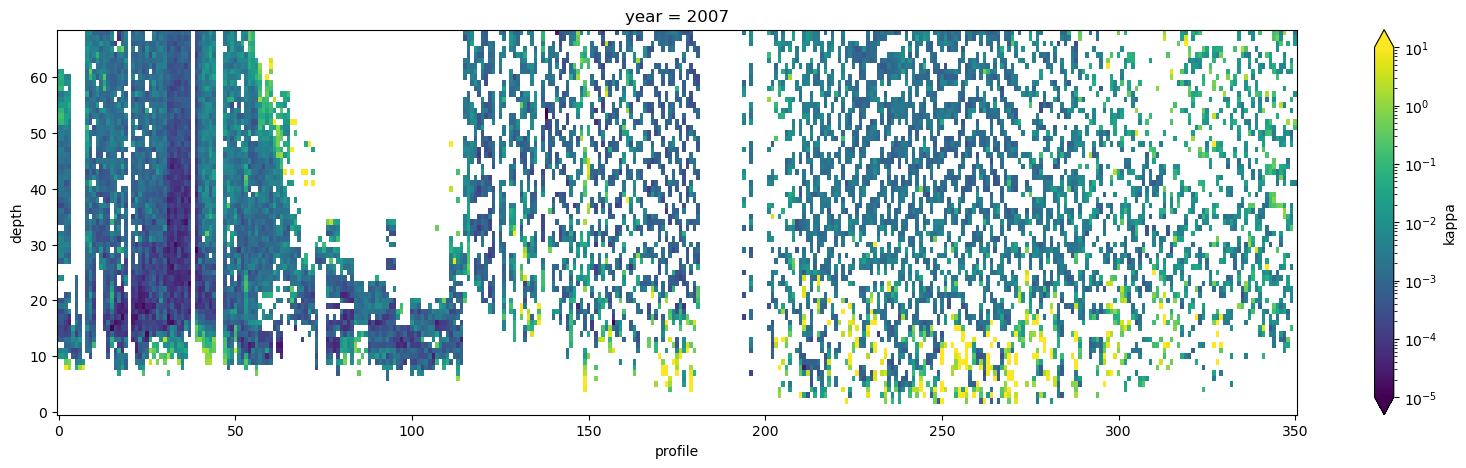

In [539]:
alberto_kappa = calc_N2_kappa(alberto_ds)
alberto_kappa.kappa.plot(y = 'depth',norm = colors.LogNorm(vmin = 1e-5, vmax = 1e1),cmap='viridis',figsize=(20,5))

/Users/Lisanne/opt/anaconda3/envs/arcticT/lib/python3.11/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


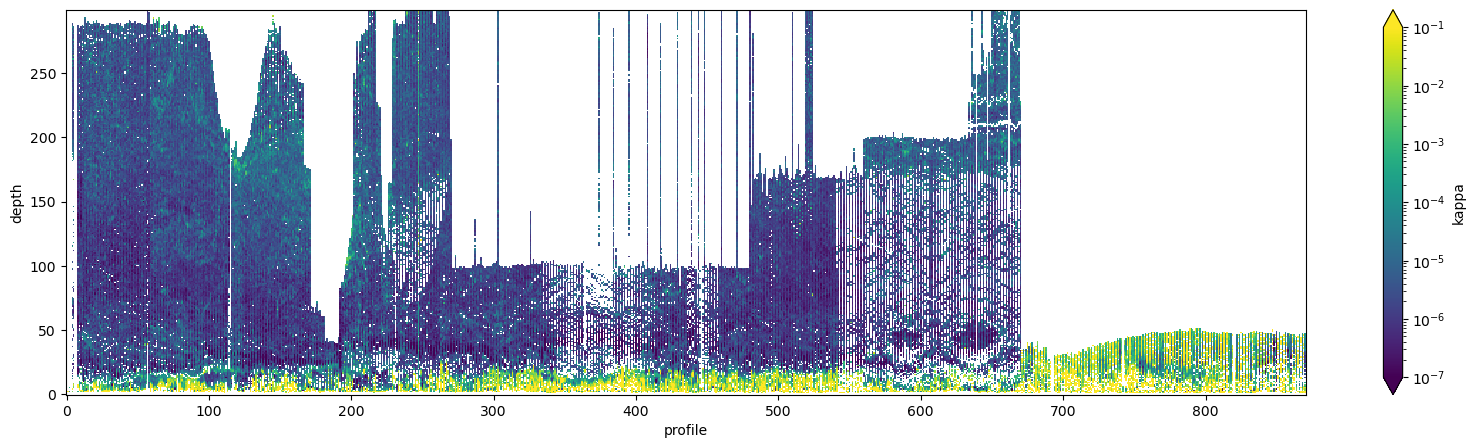

In [540]:
arctic_ds = arctic_ds.squeeze()
arctic = calc_N2_kappa(arctic_ds)
arctic.kappa.plot(y = 'depth',norm = colors.LogNorm(vmin = 1e-7, vmax = 1e-1),cmap='viridis',figsize=(20,5))

/Users/Lisanne/opt/anaconda3/envs/arcticT/lib/python3.11/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


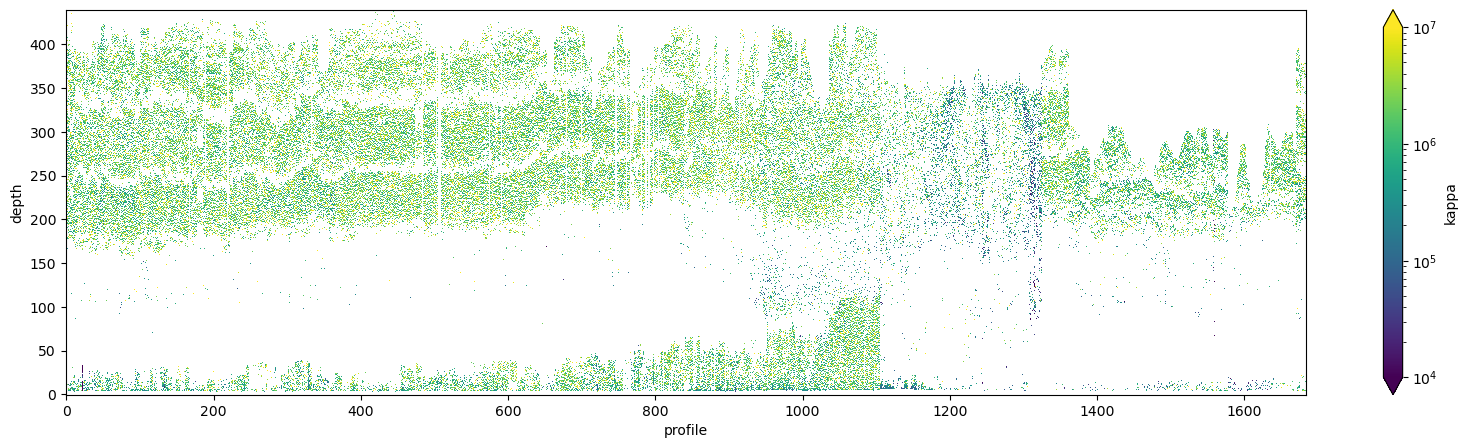

In [541]:
mosaic = calc_N2_kappa(mosaic_ds)
mosaic.kappa.plot(y = 'depth',norm = colors.LogNorm(vmin = 1e4, vmax = 1e7),cmap='viridis',figsize=(20,5))

In [ ]:
from matplotlib import colors

# define function to calculate N2
def calc_N2(rho, drho, deps):
    return (9.81 / rho) * drho / deps

def calc_N2_kappa(dataset):
    S = dataset.S
    p = dataset.P
    lon = dataset.longitude
    lat = dataset.latitude
    T = dataset.T
    eps = dataset.eps
    z = dataset.depth
    
    # convert measured T to potential T, which is seen as temperature now
    # potential temperature is the temperature a water parcel would have 
    # if it were brought to the surface adiabatically (no pressure effects)
    dataset = dataset.rename({"T": "insituT"})
    dataset["T"] = gsw.conversions.pt_from_t(S, T, p, p_ref = 0)
    
    dataset['rho'] = gsw.rho(S, T, p)
    dataset["P"] = gsw.conversions.p_from_z(dataset["depth"],
                                            dataset["latitude"])
    dataset['drhodz'] = dataset.rho.differentiate('depth')
    dataset['depsdz'] = dataset.eps.differentiate('depth')
    
    # Calculate N^2
    g = 9.81  # acceleration due to gravity
    
    # apply the calc_N2() function to the DataArray
    N2_da = xr.apply_ufunc(calc_N2, dataset.rho, dataset.drhodz, dataset.depsdz,
                           input_core_dims=[['depth'], ['depth'], ['depth']],
                           output_core_dims=[['depth']],
                           vectorize=True)

    # add the N2 DataArray to the original dataset
    dataset['N2'] = N2_da
    dataset['kappa'] = 0.2*dataset.eps/dataset.N2
    dataset["log_N2"] = np.log10(dataset.N2)
    dataset["log_kappa"] = np.log10(dataset.kappa)
    return dataset

## Hab

In [485]:
from tqdm import tqdm

In [514]:
def calc_hab(data):
    bathy_interp = bathy_ds.interp_like(data, method='nearest')
    n_depths = data.profile.shape[0]
    depth = np.zeros(n_depths)

    for i in tqdm(range(n_depths)):
        microlon = data.longitude[i].values.flatten()
        microlat = data.latitude[i].values.flatten()
        depth[i] = bathy_interp.elevation.sel(lon=microlon,lat=microlat, method='nearest')
    data['bathymetry'] = data.profile.copy(data=depth)
    
    data["hab"] = data.bathymetry + abs(data.depth)
    data["hab"] = data["hab"].where(data["hab"] <= 0, 0)  # Set positive values to zero
    return data

100%|██████████| 351/351 [00:00<00:00, 976.37it/s]


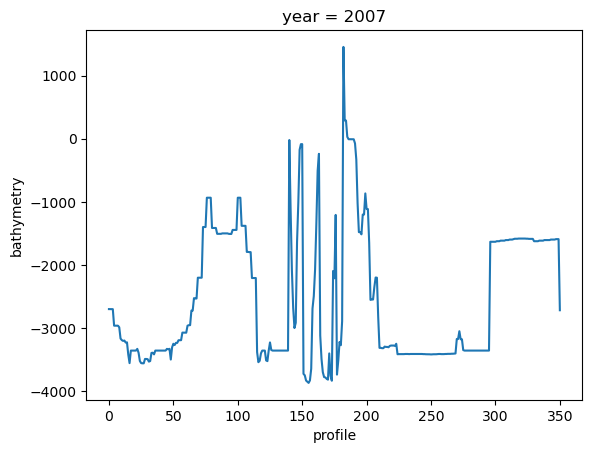

In [515]:
alberto_hab = calc_hab(alberto_ds)
alberto_hab.bathymetry.plot()

100%|██████████| 1684/1684 [00:01<00:00, 1308.15it/s]


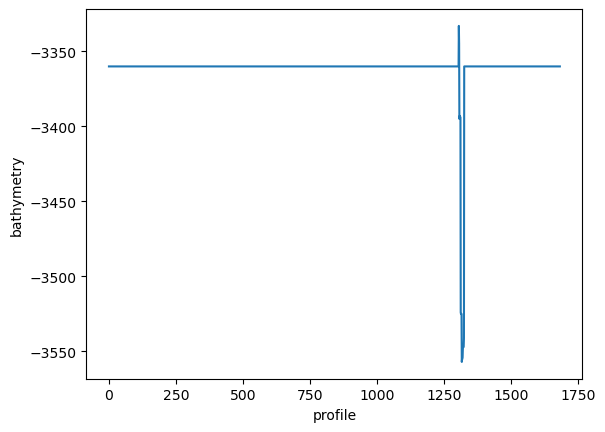

In [496]:
mosaic_hab = calc_hab(mosaic_ds)
mosaic_hab.bathymetry.plot()

100%|██████████| 588/588 [00:00<00:00, 1224.69it/s]


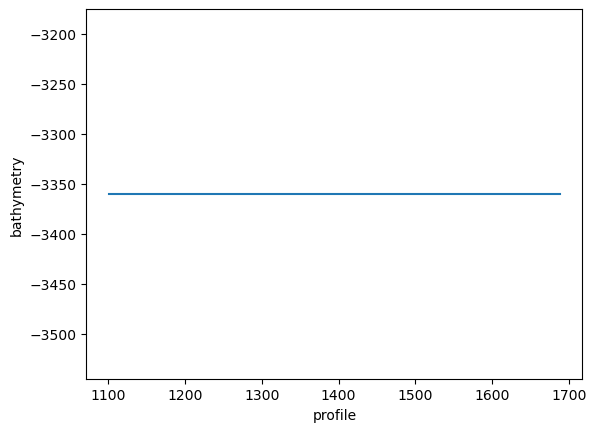

In [497]:
nice_hab = calc_hab(nice_ds)
nice_hab.bathymetry.plot()

100%|██████████| 78/78 [00:00<00:00, 733.70it/s]


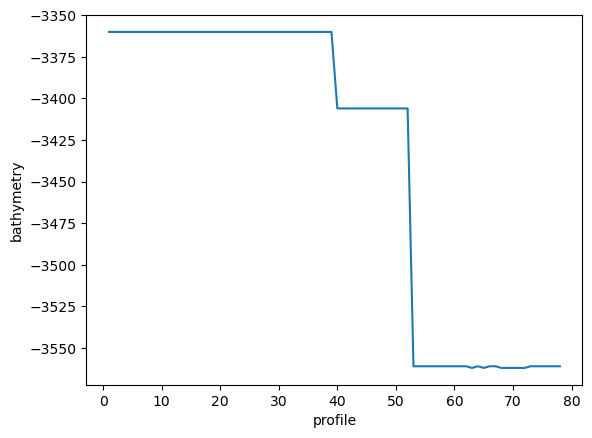

In [498]:
HM_hab = calc_hab(HM_ds)
HM_hab.bathymetry.plot()

In [572]:
def arctic_calchab(data):
    # group data by the 'profile' dimension
    profile_groups = data.groupby('profile')

    bathy_interp = bathy_ds.interp_like(data, method='nearest')
    n_profiles = len(data.depth)

    profile = np.zeros(len(profile_groups))

    # loop over each group
    for i, (_, profile_data) in tqdm(enumerate(profile_groups)):
        microlat = profile_data.latitude.values.flatten()[0]
        microlon = profile_data.longitude.values.flatten()[0]
        profile[i] = bathy_interp.elevation.sel(lon=microlon, lat=microlat, method='nearest').values

    # Create a DataArray for bathymetry with the 'profile' dimension
    profile_arr = xr.DataArray(profile, coords=[range(len(profile_groups))], dims=['profile'])
    data['bathymetry'] = profile_arr
    data["hab"] = data.bathymetry + abs(data.depth)
    data["hab"] = data["hab"].where(data["hab"] <= 0, 0)  # Set positive values to zero
    return data

871it [00:00, 1196.99it/s]


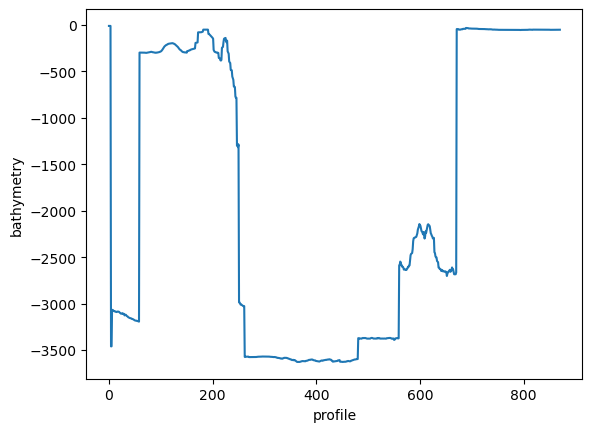

In [504]:
arctic_hab = arctic_calchab(arctic_ds)
arctic_hab.bathymetry.plot()